## Import Libraries

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
from PIL import Image

## Create Sample Dataset

In [3]:
# Define source and target directories
source_dir = "Dataset/EYE_DATASET"
target_dir = "Dataset/EYE_sample"
os.makedirs(target_dir, exist_ok=True)

# List of classes (subdirectories)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
samples_per_class = 25

sample_metadata = []

for label in classes:
    img_paths = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_paths.extend(glob(os.path.join(source_dir, label, ext)))

    if len(img_paths) < samples_per_class:
        print(f"Skipping '{label}' — not enough images found.")
        continue

    selected_imgs = np.random.choice(img_paths, size=samples_per_class, replace=False)

    for img_path in selected_imgs:
        img_name = Path(img_path).name
        new_path = os.path.join(target_dir, img_name)
        shutil.copy(img_path, new_path)
        sample_metadata.append({'image_id': img_name, 'label': label})

# Save metadata CSV
sample_df = pd.DataFrame(sample_metadata)
sample_df.to_csv(os.path.join(target_dir, "EYE_sample.csv"), index=False)

## Preprocessing

In [4]:
def preprocess_sample_data(sample_dir="Dataset/EYE_sample", image_size=224):
    df = pd.read_csv(os.path.join(sample_dir, "EYE_sample.csv"))

    images = []
    for fname in df["image_id"]:
        img = Image.open(os.path.join(sample_dir, fname)).convert("RGB").resize((image_size, image_size))
        img_arr = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
        images.append(img_arr)

    X = np.stack(images, axis=0)
    y = df["label"].tolist()

    return X, y

## Load Data and Proprocess

In [5]:
X, y_true = preprocess_sample_data()
X.shape, y_true[:5]

((100, 224, 224, 3),
 ['cataract', 'cataract', 'cataract', 'cataract', 'cataract'])

## Export Data for Quantization

In [12]:
import os
import numpy as np

quant_dir = "Models/eye_quant_data"
os.makedirs(quant_dir, exist_ok=True)

# Pad to make divisible by 3
BATCH_SIZE = 3
pad_len = (-len(X)) % BATCH_SIZE
if pad_len > 0:
    pad_shape = (pad_len, 224, 224, 3)
    X = np.concatenate([X, np.zeros(pad_shape, dtype=np.float32)])

print(f"Total padded samples: {len(X)}")

# Save .npy batches and relative dataset.txt
dataset_txt_path = os.path.join(quant_dir, "dataset.txt")
with open(dataset_txt_path, "w") as f:
    for i in range(0, len(X), BATCH_SIZE):
        batch = X[i:i+BATCH_SIZE]
        filename = f"image_{i//BATCH_SIZE:04d}.npy"
        file_path = os.path.join(quant_dir, filename)
        np.save(file_path, batch)
        f.write(filename + "\n")  # write only the filename, not the full path

print(f"Quantization data and dataset.txt saved in: {quant_dir}")


Total padded samples: 102
Quantization data and dataset.txt saved in: Models/eye_quant_data


## Load ONNX Model and Run Inference

In [8]:
import onnxruntime as ort

# Load ONNX model
onnx_model_path = "Models/EYE_81.onnx"
sess = ort.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

# Perform inference
outputs = sess.run(None, {"input": X.astype(np.float32)})
y_pred = np.argmax(outputs[0], axis=1)

## Results

=== Classification Report ===
                      precision    recall  f1-score   support

            cataract       0.91      0.84      0.88        25
diabetic_retinopathy       0.88      0.84      0.86        25
            glaucoma       0.90      0.72      0.80        25
              normal       0.61      0.80      0.69        25

            accuracy                           0.80       100
           macro avg       0.82      0.80      0.81       100
        weighted avg       0.82      0.80      0.81       100



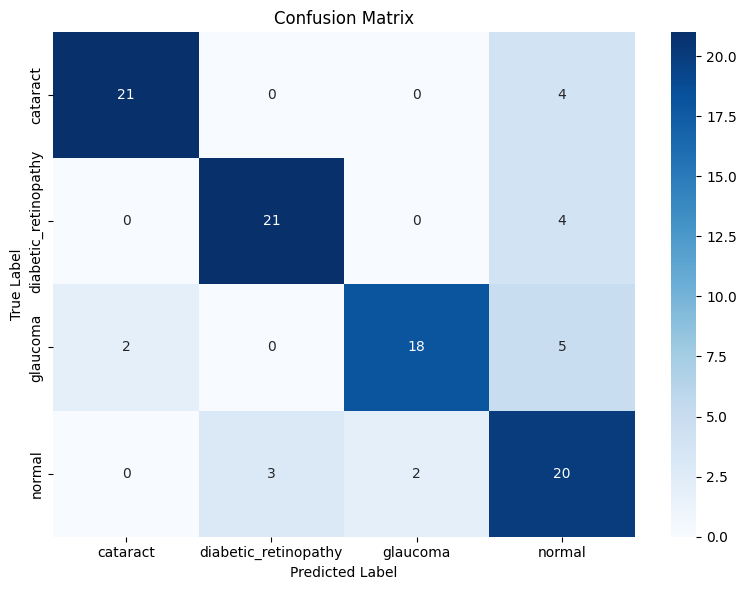

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Encode true labels
le = LabelEncoder()
y_true_enc = le.fit_transform(y_true)
class_names = le.classes_

# Classification results
report = classification_report(y_true_enc, y_pred, target_names=class_names, zero_division=0)
cm = confusion_matrix(y_true_enc, y_pred)

print("=== Classification Report ===")
print(report)
# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()